In [2]:
import numpy as np
import pandas as pd
import Fourier_Power_Spectrum
import plotting_utilities
import save_utilities
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter1d
import time 
from tqdm.notebook import tqdm 
import torch 

In [28]:
# get target data (Lilac 114, Neuron 1, epoch_1.txt)
# Column1: Current, Column2: Voltage
try:
    lilac_114_1_1 = pd.read_csv('./Data2022-50KhZ/7-7-2022/Lilac 114/Neuron 1/epoch_1.txt', delimiter='\t', header=None)
except: 
    lilac_114_1_1 = pd.read_csv('./Data2022-50KhZ/Lilac 114/Neuron 1/epoch_1.txt', delimiter='\t', header=None)
lilac_114_1_1.reset_index(inplace=True)
lilac_114_1_1.columns = ['Time', 'Current', 'Voltage']
lilac_114_1_1.head()

,Time,Current,Voltage
0,0,-4.179686,-64.490236
1,1,0.092775,-64.337648
2,2,-7.841795,-64.581788
3,3,0.092775,-64.307130
4,4,-2.958983,-64.429200


In [29]:
# plot to visualize 
# figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title("Time vs Current")
# ax1.plot(lilac_114_1_1.Time, lilac_114_1_1.Current)
# ax2.set_title("Time vs Voltage")
# ax2.plot(lilac_114_1_1.Time, lilac_114_1_1.Voltage)
# plt.show()

#### False Nearest Neighbor Algorithm to Determine Time Delay Vector Dimensionality 

##### Procedure
1. Define the target time delay vector (regressor) to run FNN on, and then generate time delay vectors for each time step of the voltage data: $\psi_{l}(t) = [y(k-\tau), ..., y(k-l \tau)] \text{ where } l\in[0, D]$.
2. For each points, identify the closest point in time delay space (we can search within a window, or through out all points), i.e. minimize this distance: $d = ||\psi_{l}(t_1) - \psi_{l}(t_2)||$.
3. The inequality below determines if two closest points are "true neighbors" or "false neighbors": $$\frac{|y(t)-y(j)|}{||\psi_l(t) - \psi_l (j)||_2} \leq R$$
    - If inequality is true, then the two points are true neighbors. 
    - If inequality is false, then the two points are false neighbors. 
4. Repeat step 3 for all points in the dataset, and then record the percentage of points in datasets with false nearest neighbors, giving the current time delay vector dimension. 
5. Increase the value of D until the percentage of false nearest neighbors is minimized. 

##### 1. Create time delay vectors

In [30]:


# TODO: change window to random sampling data from entire dataset, or start with every 1000th data points and move down on the skip size 

# TODO: save result as txt file; rows: D values, column: FNN ratio,  

In [102]:
# define tau (user provided), distance ratio threshold R (user defined hyperparameter), and range of D to search over (trainable parameter)
tau = 5
R_ratio = 10 # TODO: Investigate optimal value of R; 10 is suggested by the original paper 
D_arr = np.array([1, 2, 4, 6, 8, 10, 12, 15, 18, 20])  

# create the time delay vectors for each data points with each of the D values
original_data = lilac_114_1_1.to_numpy()
T = original_data[:, 0].astype(np.int64)
I = original_data[:, 1].astype(np.float64)
V_0 = original_data[:, 2].astype(np.float64).reshape((len(T), 1)) # voltage at 0*tau


start = time.time()
time_delay_datasets = []
for d in D_arr:
    V_s = np.dstack([np.concatenate([V_0[-i*tau:, :], V_0[:-i*tau, :]], axis=0) for i in range(d+1)])[:, 0, :]
    time_delay_datasets.append(V_s)
end = time.time()
print(f"This took {end-start}.") 

This took 0.9850034713745117.


In [104]:
# check the datasets shapes
for D_index in range(len(D_arr)): 
    print(f"For D={D_arr[D_index]}, the shape of the dataset is {time_delay_datasets[D_index].shape}")

For D=1, the shape of the dataset is (750000, 2)
For D=2, the shape of the dataset is (750000, 3)
For D=4, the shape of the dataset is (750000, 5)
For D=6, the shape of the dataset is (750000, 7)
For D=8, the shape of the dataset is (750000, 9)
For D=10, the shape of the dataset is (750000, 11)
For D=12, the shape of the dataset is (750000, 13)
For D=15, the shape of the dataset is (750000, 16)
For D=18, the shape of the dataset is (750000, 19)
For D=20, the shape of the dataset is (750000, 21)


In [107]:
# check the data 
"""
Every second element should match up with the first element of the Dth row down the line, i.e. array[0, 1] == array[D, 1] 
"""
time_delay_datasets[0][:20] 


array([[-64.49023555, -54.60254001],
       [-64.33764765, -54.4804697 ],
       [-64.58178828, -54.4804697 ],
       [-64.30713008, -54.32788181],
       [-64.42920039, -54.57202244],
       [-64.52075313, -64.49023555],
       [-64.2766125 , -64.33764765],
       [-64.36816523, -64.58178828],
       [-64.24609492, -64.30713008],
       [-64.64282344, -64.42920039],
       [-64.30713008, -64.52075313],
       [-64.2766125 , -64.2766125 ],
       [-64.58178828, -64.36816523],
       [-64.30713008, -64.24609492],
       [-64.55127071, -64.64282344],
       [-64.33764765, -64.30713008],
       [-64.67334102, -64.2766125 ],
       [-64.52075313, -64.58178828],
       [-64.24609492, -64.30713008],
       [-64.58178828, -64.55127071]])

##### 2. Calculate distance between points, and for each point, find its closest point

In [117]:
# change the data from array to tensor for faster calculation 
torch.device('cuda')

time_delay_datasets = [torch.tensor(arr) for arr in time_delay_datasets]

The process of find the nearest point for all available points in the dataset takes 2 hours (projected) for each dataset, lets try this with a smaller window=200

In [162]:
# calculate the min distance result (test) - window=200 will run for 20 mins
"""
TODO: I am trying to fix the issue with NN being to close to the target
"""

test_data = time_delay_datasets[0]

def generate_min_dist_datapoints(data, window=1000): 
    result_data, result_index = [], []
    for i in tqdm(range(len(data))): 

        # create a window of data point to search over 
        # save the starting index and the ending index of our window as reference
        start_index, end_index = max(i-window, 0), min(len(data), i+window)

        # exclude the target point from the window
        search_window = torch.cat([
            data[start_index:i], 
            data[i+1:end_index]
        ]) 
        # print(search_window)

        # run the distance calculation and find the closest point and their indices
        distance = torch.norm(search_window - data[i], dim=1)
        # print(search_window - data[i])
        # print(torch.norm(search_window - data[i], dim=1))
        min_distance_index = torch.argmin(distance) # index of minimum distance point inside the window of datapoints 
        print(min_distance_index)
        min_distance_pair_data = [data[i].data, search_window[min_distance_index].data]

        # find the real index in respect to the entire dataset 
        real_min_distance_index = start_index + min_distance_index + 1 if start_index + min_distance_index >= i else start_index + min_distance_index
        min_distance_pair_index = [i, real_min_distance_index.data]

        # save the closest point's index
        # this is the k and j: index of the first and second data points 
        result_data.append(min_distance_pair_data)
        result_index.append(min_distance_pair_index)

        # early stopping for testing purposes 
        if i == 0: 
            break
    
    # convert the list to numpy array 
    result_data = np.array(result_data)
    result_index = np.array(result_index)

    
    # print("Saving results...")
    # np.save(f'min_datapairs_D={test_data.shape[1]}_window={window}_datapoints', result_data)
    # np.save(f'min_datapairs_D={test_data.shape[1]}_window={window}_location', result_index)
    # print("Results saved.")
    return result_data, result_index

# print(test_data)
test_data, test_index = generate_min_dist_datapoints(test_data)
test_data, test_index

  0%|          | 0/750000 [00:00<?, ?it/s]

tensor(3)


C:\Users\xueze\AppData\Local\Temp\ipykernel_23264\3244217045.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result_data = np.array(result_data)
C:\Users\xueze\AppData\Local\Temp\ipykernel_23264\3244217045.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_data = np.array(result_data)


(array([[tensor([-64.4902, -54.6025], dtype=torch.float64),
         tensor([-64.4292, -54.5720], dtype=torch.float64)]], dtype=object),
 array([[0, 4]], dtype=int64))

In [5]:
import numpy as np 

fp = "./FNN/FNN_min-dist_results/min_datapairs_D=20_window=100000_datapoints.npy"
arr = np.load(fp)
# arr[:5]

##### 3. Count the number of False Nearest Neighbors and True Nearest Neighbors in the current setup 

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import Fourier_Power_Spectrum
import plotting_utilities
import save_utilities
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter1d
import time 
from tqdm.notebook import tqdm 
import torch 

In [4]:
# load from all the npy file
import os 
import re 

D_data_dict, D_index_dict = {}, {}
root = "./FNN/FNN_min-dist_results/"
try: 
    os.listdir(root)
except:
    root = "./FNN/"

for filepath in os.listdir(root): 
    if 'min_datapairs' not in filepath: 
        continue
    # print(filepath)
    D = int(re.search("D=([0-9]*)", filepath).group(1))
    window_size = int(re.search("window=([0-9]*)", filepath).group(1))
    data = True if re.search("datapoints", filepath) else False
    if data:
        D_data_dict[(D, window_size)] = np.load(root+filepath)
    else: 
        D_index_dict[(D, window_size)] = np.load(root+filepath)

In [37]:
def count_fnn(index, dataset, threshold_R=1e-2):
    """
    Parameters: 
    dataset: A dataset should contain all the points and their closest point in pairs; example [(point_vec1, point_vec2)_1, (point_vec1, point_vec2)_2, ...]
    threshold_R: This threshold determines ratio needed between the actual distance and the time delay distance to be recognized as a true nearest neighbor

    Return: 
    A floating point number indicating the number of false nearest neighbors in the dataset. 
    """
    counter = 0
    tnn, fnn = 0, 0
    for i in range(index.shape[0]): 
        td1, td2 = dataset[i] # time delay vectors 
        true1, true2 = td1[0], td2[0] # the first value of each time delay vectors are the true voltage value 
        time_dist = np.linalg.norm(td1 - td2, ord=2) # time delay distance between the two points 
        actual_dist = np.abs(true1 - true2) # actual distance 
        dist_ratio = actual_dist / time_dist
        
        # dist_ratio = actual_dist / time_dist if time_dist != 0 else 0
        if dist_ratio >= threshold_R: # determine falsehood 
            fnn += 1
        else: 
            tnn += 1
        counter += 1

    return fnn / (fnn+tnn)

In [38]:
# evaluate each dataset's FNN ratio with different R values 

D_results = defaultdict(list) # list of fnn ratios for each (D, window_size combo)

exp = np.concatenate([np.arange(5, -1, -1), np.arange(-1, -5, -1)]) # array([ 5,  4,  3,  2,  1,  0, -1, -2, -3, -4])

for (d, window), d_data in tqdm(D_data_dict.items()):
    for e in exp:
        R = float(f'1e{e}')
        fnn_ratio = count_fnn(D_index_dict[(d, window)], d_data, threshold_R=R)
        D_results[(d, window)].append(fnn_ratio)

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\xueze\AppData\Local\Temp\ipykernel_9116\177392557.py:17: RuntimeWarning: invalid value encountered in float_scalars
  dist_ratio = actual_dist / time_dist


In [39]:
# divide the graph into two plots by windows, and sort by D values 
D_100000 = {}
D_1000 = {}

for (d, window_size), lst in D_results.items(): 
    if window_size == 1000: 
        D_1000[d] = lst
    if window_size == 100000: 
        D_100000[d] = lst

D_1000 = dict(sorted(D_1000.items(), key=lambda x: x[0]))
D_100000 = dict(sorted(D_100000.items(), key=lambda x: x[0]))

In [40]:
# plot fnn vs R for each D
def matrix_plot(D_results, window, r=5): 
    c=len(D_results)//r
    fig, axes = plt.subplots(r, c, figsize=(18, 14))
    fig.tight_layout(pad=3.0)
    r_i, c_i = 0, 0
    for d, fnn_data in D_results.items(): 
        axes[r_i, c_i].set_title(f'D={d}, window={window}')
        axes[r_i, c_i].set_xlabel("R's Exponents")
        axes[r_i, c_i].set_ylabel("FNN Ratio")
        axes[r_i, c_i].scatter(exp, fnn_data)
        c_i +=1
        if c_i == c:
            c_i = 0
            r_i +=1


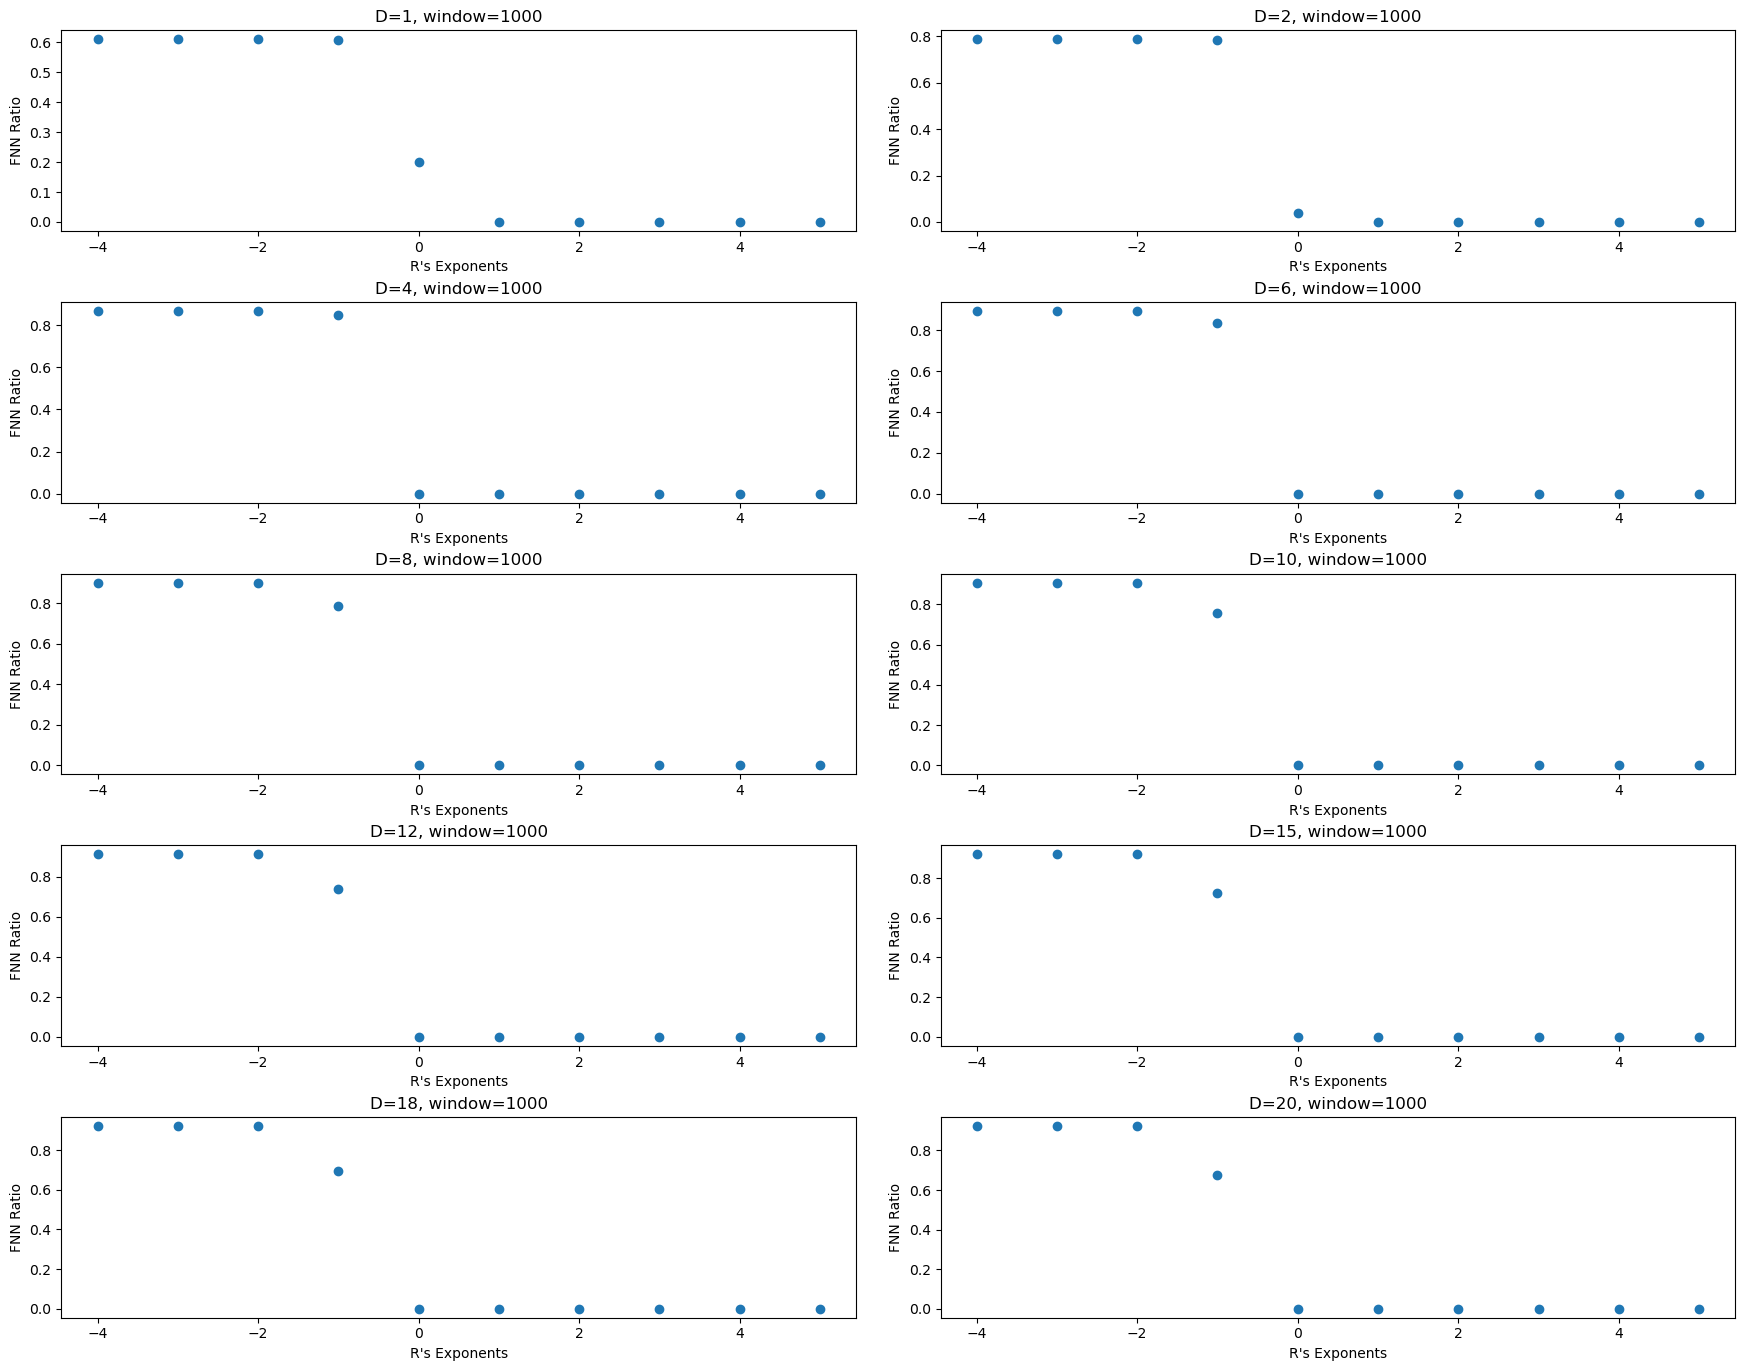

In [41]:
matrix_plot(D_1000, 1000, r=5)

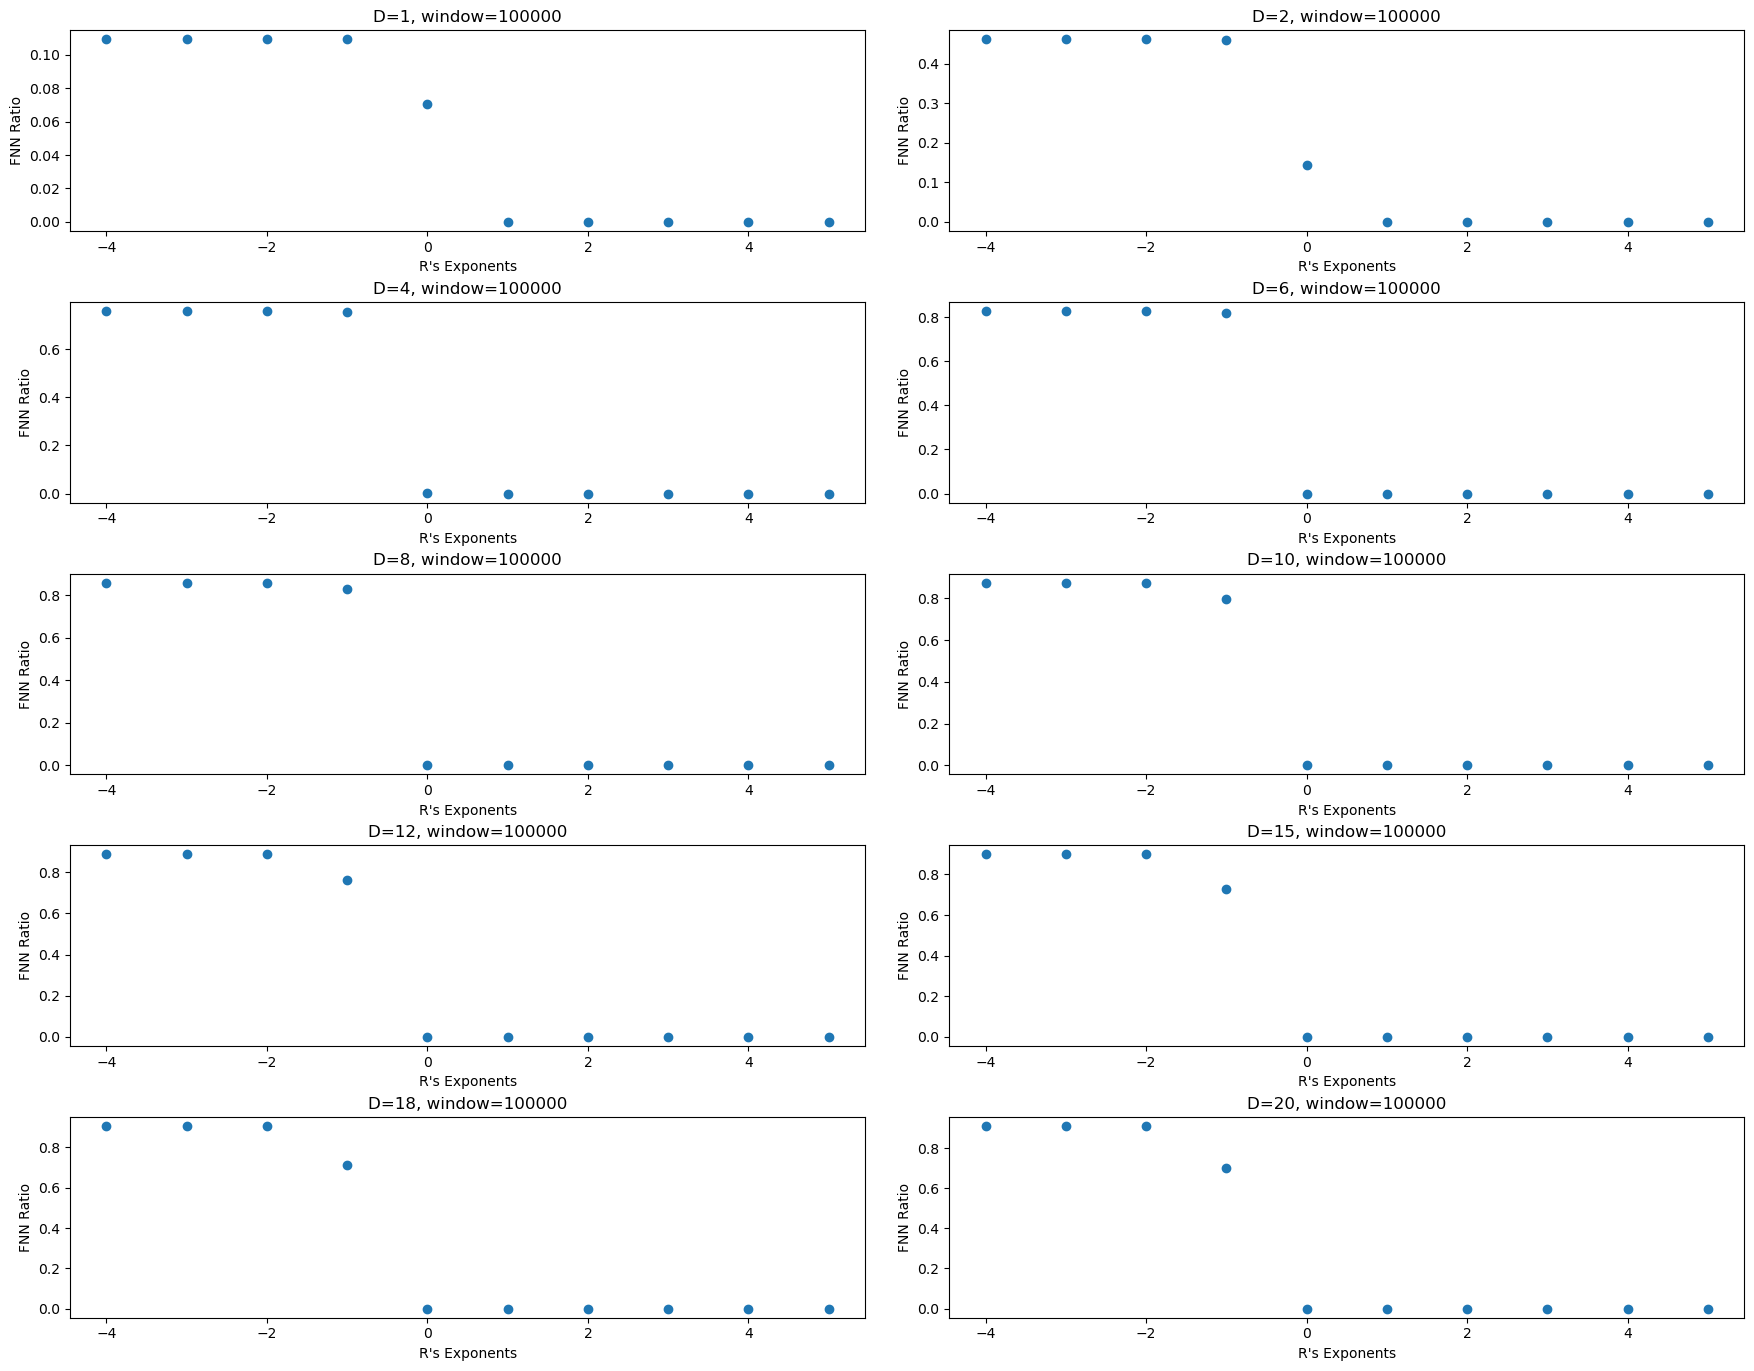

In [42]:
matrix_plot(D_100000, 100000)

Intuitively, R=1e-1 seems to make the most sense

##### 4. Repeat the search for all D values

In [26]:
# iterate through the D array and run the ratio calculation algorithm 
# from collections import defaultdict
# result = defaultdict(float)
# for d_index in range(len(D_arr)): 
#     dataset = time_delay_datasets[d_index] # get the time delay vectors 
#     min_dist_vector_pairs = generate_min_dist_datapoints(dataset) # generate data pairs 
#     result[D_arr[d_index]] = count_fnn(min_dist_vector_pairs)
    

In [52]:
# extract fnn ratios from window=1000, and window = 100000 for R between 1e-2, 1e-1, 1
D_results = defaultdict(list) # list of fnn ratios for each (D, window_size combo)

exp = np.array([0, -0.25, -0.5, -0.75, -1, -1.25, -1.5, -1.75, -2]) 

for (d, window), d_data in tqdm(D_data_dict.items()):
    for e in exp:
        R = np.power(10, e)
        fnn_ratio = count_fnn(D_index_dict[(d, window)], d_data, threshold_R=R)
        D_results[(d, window)].append(fnn_ratio)


D_100000 = {}
D_1000 = {}

for (d, window_size), lst in D_results.items(): 
    if window_size == 1000: 
        D_1000[d] = lst
    if window_size == 100000: 
        D_100000[d] = lst

D_1000 = dict(sorted(D_1000.items(), key=lambda x: x[0]))
D_100000 = dict(sorted(D_100000.items(), key=lambda x: x[0]))


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\xueze\AppData\Local\Temp\ipykernel_9116\177392557.py:17: RuntimeWarning: invalid value encountered in float_scalars
  dist_ratio = actual_dist / time_dist


In [53]:
exp = []
for i in np.array([0, -0.25, -0.5, -0.75, -1, -1.25, -1.5, -1.75, -2]): 
    exp.append(round(np.power(10, i), 2))

In [58]:
def reformat_dict(D_results, R_vals): 
    new_dict = defaultdict(list)
    d_list = []
    for d, fnn_by_r in D_results.items():
        d_list.append(d)
        for i in range(len(fnn_by_r)): 
            new_dict[R_vals[i]].append(fnn_by_r[i])
    return d_list, new_dict

d_1000, fnn_by_d_1000 = reformat_dict(D_1000, exp)
d_100000, fnn_by_d_100000 = reformat_dict(D_100000, exp)

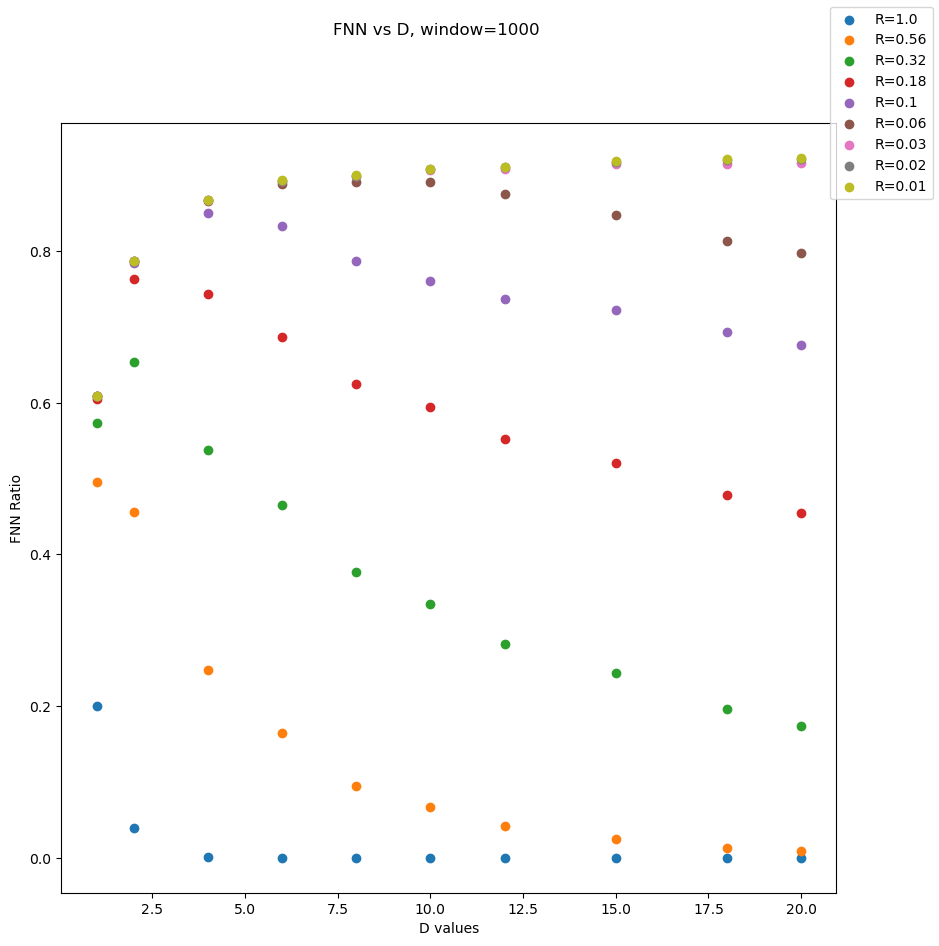

In [69]:
def plot_matrix_fnn_D(R_results, D_vals, R_vals, window, r=3):
    c = len(R_results)//r
    
    fig = plt.figure(figsize=(10,10))
    axs = plt.axes()
    plt.suptitle(f'FNN vs D, window={window}')
    axs.set_xlabel("D values")
    axs.set_ylabel("FNN Ratio")
    for i in range(len(R_vals)): 
        fnn_D = R_results[R_vals[i]] 
        axs.scatter(D_vals, fnn_D, label=f"R={R_vals[i]}")
    fig.legend()
    plt.show()
    
plot_matrix_fnn_D(fnn_by_d_1000, d_1000, exp, 1000)

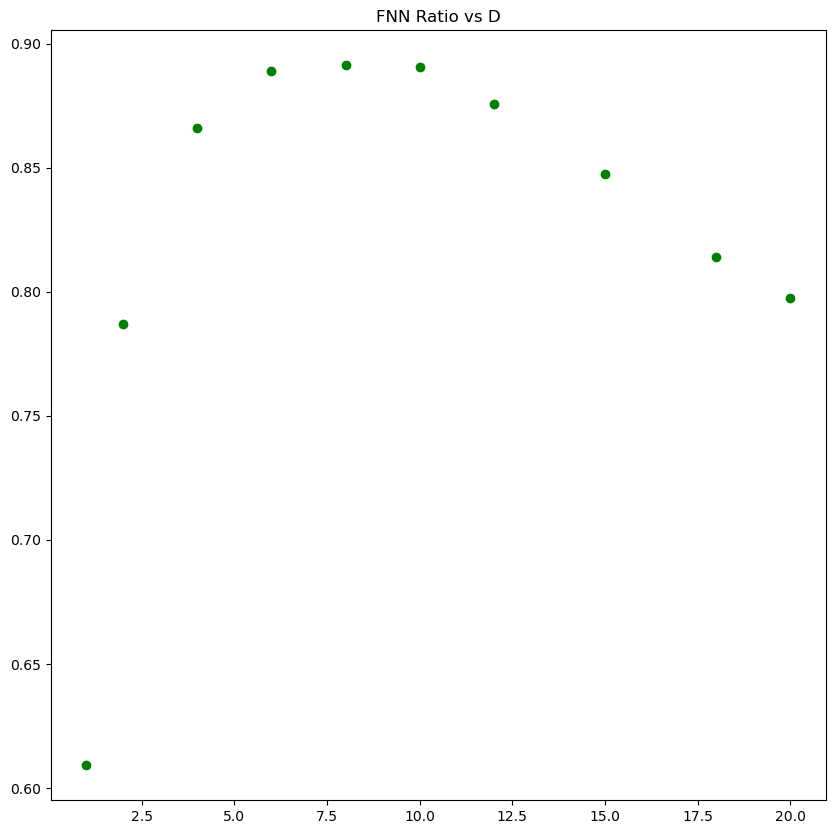

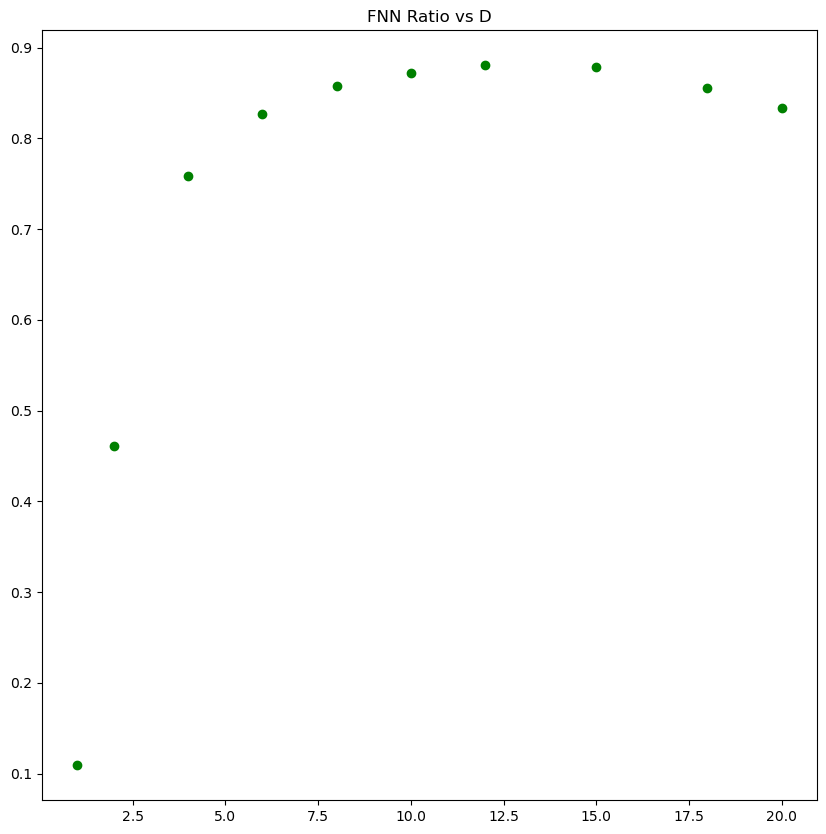

In [76]:
data = []
for (d, window), fnn_data in D_results.items(): 
    data.append((d, fnn_data[4])) # get fnn for R's exponent is -1 for all D values 

# extra sorting step because the order for D is weird 
data = sorted(data, key=lambda x: x[0])

D_1000, D_100000 =[], []
fnn_lst_1000, fnn_lst_100000 = [], []

for i in range(len(data)): 
    if i%2==0:
        D_1000.append(data[i][0])   
        fnn_lst_1000.append(data[i][1])
    else: 
        D_100000.append(data[i][0])
        fnn_lst_100000.append(data[i][1])

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_title("FNN Ratio vs D")
plt.scatter(D_100000, fnn_lst_100000, c='green')
plt.show()

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_title("FNN Ratio vs D")
plt.scatter(D_1000, fnn_lst_1000, c='green')
plt.show()

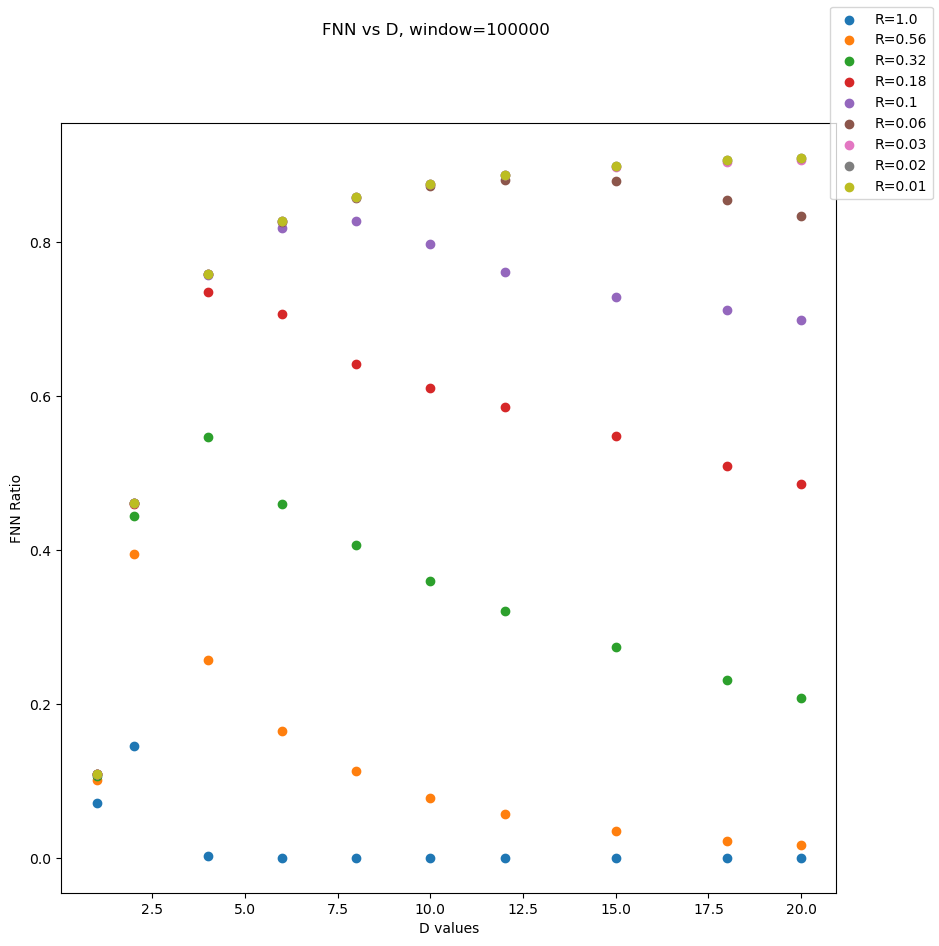

In [71]:
plot_matrix_fnn_D(fnn_by_d_100000, d_100000, exp, 100000)